In [1]:
# All imported libraries are listed herefor readbility

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from zlib import crc32



# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer


# The Linear Regression model
from sklearn.linear_model import LinearRegression

# Early version of chords GUI interface
from chords_gui import chords_gui 


In [2]:
# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [3]:
chords.select_data_file()

Available Data Files


Output()

In [4]:
# Get the selected file to use
file_name = chords.available_data_files.value
print(file_name)

# Load the data
original_data = chords.load_data_from_file(file_name)

tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


<AxesSubplot:xlabel='Height', ylabel='Latitude'>

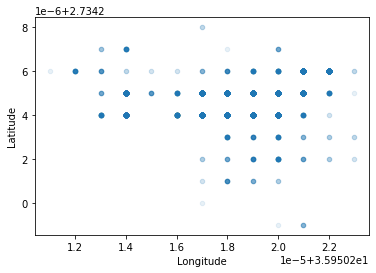

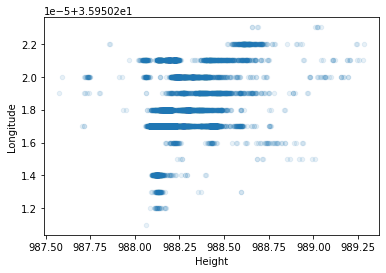

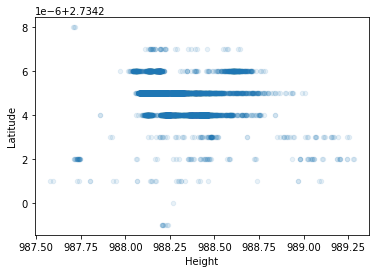

In [5]:
original_data.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Longitude", alpha=0.1)
original_data.plot(kind="scatter", x="Height", y="Latitude", alpha=0.1)

In [6]:
# Calculate the seconds_since_epoch variable
original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [7]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height', 'seconds_since_epoch'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [8]:
# swap the order of the columns
columns_titles = ["seconds_since_epoch","Height"]
height_data=height_data.reindex(columns=columns_titles)

height_data.keys()

Index(['seconds_since_epoch', 'Height'], dtype='object')

In [9]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
height_data_imputed = num_pipeline.fit_transform(height_data)

height_data_imputed

array([[-1.92315891,  1.04711994],
       [-1.92311557, -4.33051854],
       [-1.92307224, -4.29589855],
       ...,
       [ 1.81034699, -0.75311955],
       [ 1.81039033, -0.66079957],
       [ 1.81043366, -0.60309959]])

<AxesSubplot:xlabel='seconds_since_epoch', ylabel='Height'>

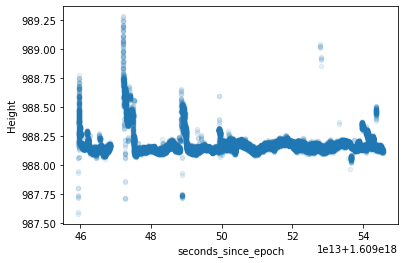

In [10]:
height_data.plot(kind="scatter", x="seconds_since_epoch", y="Height", alpha=0.1)

In [11]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

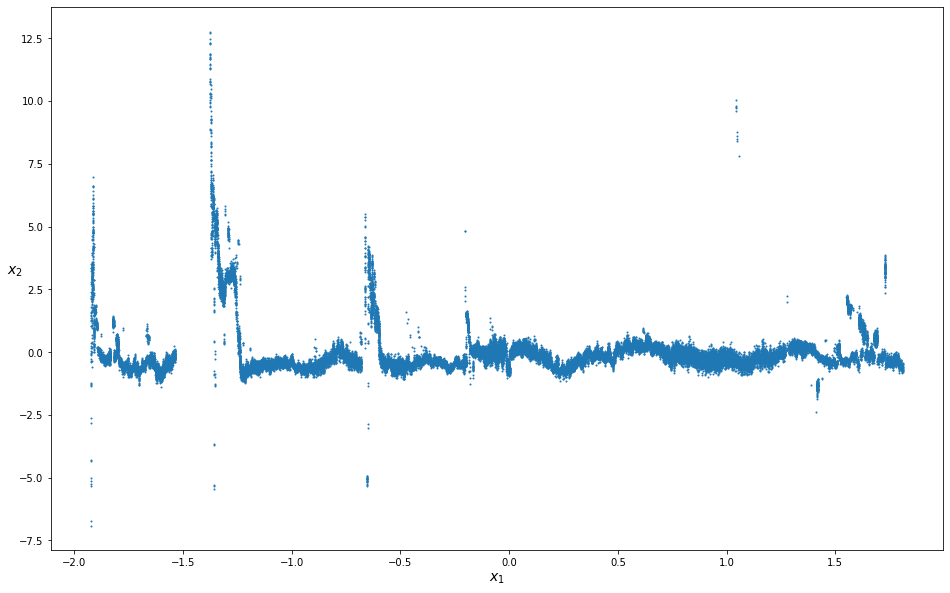

In [12]:
plt.figure(figsize=(16, 10))
plot_clusters(height_data_imputed)
plt.show()

In [13]:
from sklearn.cluster import KMeans


In [14]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(height_data_imputed)

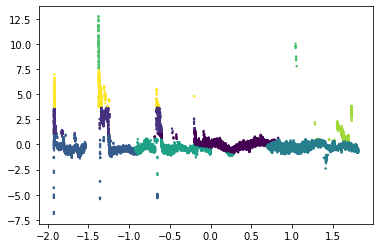

In [15]:
# Useful K-means article
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
plt.scatter(height_data_imputed[:, 0], height_data_imputed[:, 1], c=y_pred,
            s=2, cmap='viridis');

In [16]:
y_pred is kmeans.labels_

True

In [17]:
kmeans.cluster_centers_

array([[ 0.2462576 ,  0.01683516],
       [-1.15327965,  2.43265422],
       [-1.38796944, -0.49917291],
       [ 1.11813954, -0.19160029],
       [-0.48312246, -0.42169927],
       [-1.05065961,  9.86321585],
       [ 1.63437361,  1.14070142],
       [-1.34827143,  5.0057027 ]])

In [18]:
kmeans.labels_

array([1, 2, 2, ..., 3, 3, 3], dtype=int32)

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [20]:
X = height_data_imputed

In [21]:
print(type(height_data))
print(type(height_data_imputed))
print(type(X))


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


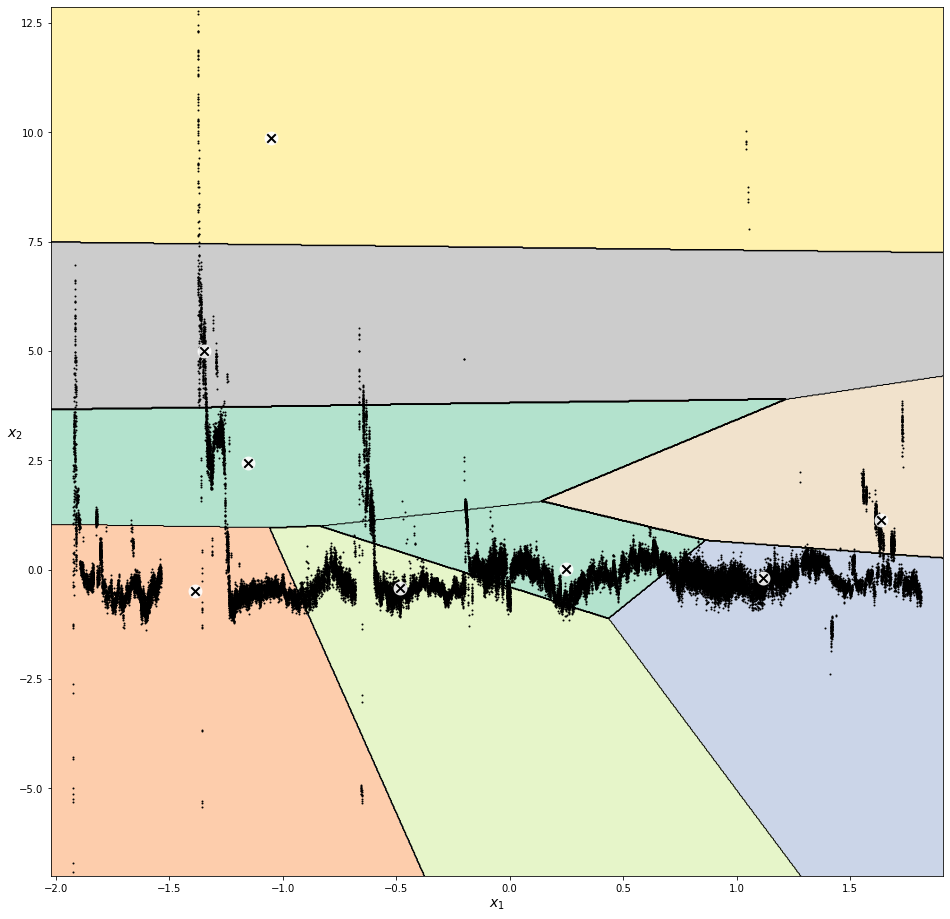

In [22]:
plt.figure(figsize=(16, 16))

plot_decision_boundaries(kmeans, height_data_imputed)

plt.show()